<a href="https://www.kaggle.com/code/yorkyong/m5-forecasting-autogluon-scalability?scriptVersionId=205780843" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<div class ="alert alert-block alert-warning">
    
- This notebook aims to apply AutoGluon-TimeSeries as covered by https://paperswithcode.com/paper/autogluon-timeseries-automl-for-probabilistic on the M5 dataset

- we aim to deploy it and run on the validation set having successfully implemented on 1 time-series in https://www.kaggle.com/code/yorkyong/m5-forecasting-autogluon-1series

# Import Libraries

In [1]:
pip install autogluon thinc==8.2.5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.0/138.0 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.4 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of spacy to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.5/259.5 kB 17.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of openxlab to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of openxlab to de

In [2]:
import gc
import os
import psutil

import pandas as pd  # For data manipulation
import numpy as np  # For numerical operations
import warnings  # To suppress warnings
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
from autogluon.timeseries.utils.forecast import get_forecast_horizon_index_ts_dataframe
from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings('ignore')  # Suppress warnings for cleaner output

import random  # For generating random numbers

# Function to set a fixed random seed for reproducibility
def seed_everything(seed):
    np.random.seed(seed)  # Set numpy random seed
    random.seed(seed)  # Set built-in random seed

seed_everything(seed=2024)  # Set the seed to 2024


# Load Dataset

In [3]:
calendar = pd.read_csv("/kaggle/input/m5-forecasting-accuracy/calendar.csv")  # Load calendar dataset
print(f"len(calendar):{len(calendar)}")  # Print the number of rows in calendar
calendar

len(calendar):1969


,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,2016-06-15,11620,Wednesday,5,6,2016,d_1965,NaN,NaN,NaN,NaN,0,1,1
1965,2016-06-16,11620,Thursday,6,6,2016,d_1966,NaN,NaN,NaN,NaN,0,0,0
1966,2016-06-17,11620,Friday,7,6,2016,d_1967,NaN,NaN,NaN,NaN,0,0,0
1967,2016-06-18,11621,Saturday,1,6,2016,d_1968,NaN,NaN,NaN,NaN,0,0,0


In [4]:
sales_train_evaluation = pd.read_csv("/kaggle/input/m5-forecasting-accuracy/sales_train_evaluation.csv")
print(f"len(sales_train_evaluation): {len(sales_train_evaluation)}")
sales_train_evaluation.head()

len(sales_train_evaluation): 30490


,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0


In [5]:
sell_prices = pd.read_csv("/kaggle/input/m5-forecasting-accuracy/sell_prices.csv")
print(f"len(sell_prices):{len(sell_prices)}")
sell_prices

len(sell_prices):6841121


,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26
...,...,...,...,...
6841116,WI_3,FOODS_3_827,11617,1.00
6841117,WI_3,FOODS_3_827,11618,1.00
6841118,WI_3,FOODS_3_827,11619,1.00
6841119,WI_3,FOODS_3_827,11620,1.00


In [6]:
# Enhanced memory optimization function with object datatype handling
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2  # Initial memory usage in MB
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:  # Downcast numerics
            c_min, c_max = df[col].min(), df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
        elif col_type == 'object':  # Handle object types
            if col == 'date':  # Convert date column to datetime
                df[col] = pd.to_datetime(df[col], format='%Y-%m-%d')
            else:
                df[col] = df[col].astype('category')  # Convert other object types to category
    end_mem = df.memory_usage().sum() / 1024**2  # Final memory usage in MB
    if verbose:
        print(f'Memory usage reduced to {end_mem:5.2f} Mb ({100 * (start_mem - end_mem) / start_mem:.1f}% reduction)')
    return df

In [7]:
# Apply the optimized memory reduction function to each dataframe
calendar = reduce_mem_usage(calendar)
sell_prices = reduce_mem_usage(sell_prices)
sales_train_evaluation = reduce_mem_usage(sales_train_evaluation)

Memory usage reduced to  0.13 Mb (40.4% reduction)
Memory usage reduced to 45.76 Mb (78.1% reduction)
Memory usage reduced to 96.30 Mb (78.7% reduction)


# Convert Sales Data to Long format

In [8]:
# Specify day columns up to d_1941 for the extended dataset
d_cols_eval = [f"d_{i}" for i in range(1, 1942)]
sales_train_evaluation_long = sales_train_evaluation.melt(
    id_vars=["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"],
    value_vars=d_cols_eval,
    var_name="d",
    value_name="sales"
)
print(f"len(sales_train_evaluation_long): {len(sales_train_evaluation_long)}")
sales_train_evaluation_long.head()

len(sales_train_evaluation_long): 59181090


,id,item_id,dept_id,cat_id,store_id,state_id,d,sales
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0


# Label Endcode Calendar event

In [9]:
# Encode event-related features in the calendar dataframe
event_columns = ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
le = LabelEncoder()
for col in event_columns:
    calendar[col] = le.fit_transform(calendar[col].astype(str))

# Merge with Calender data

In [10]:
sales_train_evaluation_long = sales_train_evaluation_long.merge(calendar, on="d", how="left")
sales_train_evaluation_long.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,1,2011,30,4,4,2,0,0,0
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,1,2011,30,4,4,2,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,1,2011,30,4,4,2,0,0,0
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,1,2011,30,4,4,2,0,0,0
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,1,2011,30,4,4,2,0,0,0


# Merge with Price data

In [11]:
sales_train_evaluation_long = sales_train_evaluation_long.merge(
    sell_prices, 
    on=["store_id", "item_id", "wm_yr_wk"], 
    how="left"
)
sales_train_evaluation_long.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,30,4,4,2,0,0,0,NaN
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,30,4,4,2,0,0,0,NaN
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,30,4,4,2,0,0,0,NaN
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,30,4,4,2,0,0,0,NaN
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,30,4,4,2,0,0,0,NaN


# Define Train, Validation and Evaluation sets

In [12]:
train_set = sales_train_evaluation_long[sales_train_evaluation_long['d'].isin([f'd_{i}' for i in range(1500, 1914)])]
print("Train set sample:")
print(f"len(Train set): {len(train_set)}")
train_set.head()

Train set sample:
len(Train set): 11128850


,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
47198520,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1549,0,2015-04-26,11513,...,4,2015,30,4,4,2,0,0,0,8.257812
47198521,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1549,0,2015-04-26,11513,...,4,2015,30,4,4,2,0,0,0,3.970703
47198522,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1549,0,2015-04-26,11513,...,4,2015,30,4,4,2,0,0,0,2.970703
47198523,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1549,3,2015-04-26,11513,...,4,2015,30,4,4,2,0,0,0,4.640625
47198524,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1549,0,2015-04-26,11513,...,4,2015,30,4,4,2,0,0,0,2.880859


In [13]:
# Filter the validation set for d_1914 to d_1941
validation_set = sales_train_evaluation_long[sales_train_evaluation_long['d'].isin([f'd_{i}' for i in range(1914, 1942)])]
print("Validation set sample:")
print(f"len(Validation set): {len(validation_set)}")
validation_set.head()


Validation set sample:
len(Validation set): 853720


,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
58327370,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1914,0,2016-04-25,11613,...,4,2016,30,4,4,2,0,0,0,8.382812
58327371,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1914,0,2016-04-25,11613,...,4,2016,30,4,4,2,0,0,0,3.970703
58327372,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1914,0,2016-04-25,11613,...,4,2016,30,4,4,2,0,0,0,2.970703
58327373,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1914,0,2016-04-25,11613,...,4,2016,30,4,4,2,0,0,0,4.640625
58327374,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1914,1,2016-04-25,11613,...,4,2016,30,4,4,2,0,0,0,2.880859


In [14]:
# Create a new DataFrame for the prediction period (d_1942 to d_1969)
forecast_days = [f'd_{i}' for i in range(1942, 1970)]
forecast_df = pd.DataFrame({'d': forecast_days})

# Generate one entry per product-store combination for each forecast day
prediction_set = sales_train_evaluation[['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']].drop_duplicates()
prediction_set = prediction_set.merge(forecast_df, how='cross')

# Merge with calendar data to add date information for the forecast period
prediction_set = prediction_set.merge(calendar, on='d', how='left')

# Merge with sell_prices to add price data, aligning with the correct store, item, and week
prediction_set = prediction_set.merge(sell_prices, on=['store_id', 'item_id', 'wm_yr_wk'], how='left')

print("Prediction set sample:")
print(f"len(Prediction set): {len(prediction_set)}")
prediction_set.head()


Prediction set sample:
len(Prediction set): 853720


,id,item_id,dept_id,cat_id,store_id,state_id,d,date,wm_yr_wk,weekday,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1942,2016-05-23,11617,Monday,...,5,2016,30,4,4,2,0,0,0,8.382812
1,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1943,2016-05-24,11617,Tuesday,...,5,2016,30,4,4,2,0,0,0,8.382812
2,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1944,2016-05-25,11617,Wednesday,...,5,2016,30,4,4,2,0,0,0,8.382812
3,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1945,2016-05-26,11617,Thursday,...,5,2016,30,4,4,2,0,0,0,8.382812
4,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1946,2016-05-27,11617,Friday,...,5,2016,30,4,4,2,0,0,0,8.382812


In [15]:
# Apply the optimized memory reduction function to each dataframe
train_set = reduce_mem_usage(train_set)
validation_set = reduce_mem_usage(validation_set)
prediction_set = reduce_mem_usage(prediction_set)

Memory usage reduced to 468.32 Mb (43.5% reduction)
Memory usage reduced to 36.34 Mb (44.0% reduction)
Memory usage reduced to 28.20 Mb (50.3% reduction)


In [16]:
train_set

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
47198520,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1549,0,2015-04-26,11513,...,4,2015,30,4,4,2,0,0,0,8.257812
47198521,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1549,0,2015-04-26,11513,...,4,2015,30,4,4,2,0,0,0,3.970703
47198522,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1549,0,2015-04-26,11513,...,4,2015,30,4,4,2,0,0,0,2.970703
47198523,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1549,3,2015-04-26,11513,...,4,2015,30,4,4,2,0,0,0,4.640625
47198524,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1549,0,2015-04-26,11513,...,4,2015,30,4,4,2,0,0,0,2.880859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58327365,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,d_1913,1,2016-04-24,11613,...,4,2016,30,4,4,2,0,0,0,2.980469
58327366,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,d_1913,0,2016-04-24,11613,...,4,2016,30,4,4,2,0,0,0,2.480469
58327367,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,d_1913,0,2016-04-24,11613,...,4,2016,30,4,4,2,0,0,0,3.980469
58327368,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,d_1913,3,2016-04-24,11613,...,4,2016,30,4,4,2,0,0,0,1.280273


In [17]:
validation_set

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
58327370,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1914,0,2016-04-25,11613,...,4,2016,30,4,4,2,0,0,0,8.382812
58327371,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1914,0,2016-04-25,11613,...,4,2016,30,4,4,2,0,0,0,3.970703
58327372,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1914,0,2016-04-25,11613,...,4,2016,30,4,4,2,0,0,0,2.970703
58327373,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1914,0,2016-04-25,11613,...,4,2016,30,4,4,2,0,0,0,4.640625
58327374,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1914,1,2016-04-25,11613,...,4,2016,30,4,4,2,0,0,0,2.880859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59181085,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,d_1941,1,2016-05-22,11617,...,5,2016,30,4,4,2,0,0,0,2.980469
59181086,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,d_1941,0,2016-05-22,11617,...,5,2016,30,4,4,2,0,0,0,2.480469
59181087,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,d_1941,2,2016-05-22,11617,...,5,2016,30,4,4,2,0,0,0,3.980469
59181088,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,d_1941,0,2016-05-22,11617,...,5,2016,30,4,4,2,0,0,0,1.280273


In [18]:
prediction_set

,id,item_id,dept_id,cat_id,store_id,state_id,d,date,wm_yr_wk,weekday,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1942,2016-05-23,11617,Monday,...,5,2016,30,4,4,2,0,0,0,8.382812
1,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1943,2016-05-24,11617,Tuesday,...,5,2016,30,4,4,2,0,0,0,8.382812
2,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1944,2016-05-25,11617,Wednesday,...,5,2016,30,4,4,2,0,0,0,8.382812
3,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1945,2016-05-26,11617,Thursday,...,5,2016,30,4,4,2,0,0,0,8.382812
4,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1946,2016-05-27,11617,Friday,...,5,2016,30,4,4,2,0,0,0,8.382812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
853715,FOODS_3_827_WI_3_evaluation,FOODS_3_827,FOODS_3,FOODS,WI_3,WI,d_1965,2016-06-15,11620,Wednesday,...,6,2016,30,4,4,2,0,1,1,1.000000
853716,FOODS_3_827_WI_3_evaluation,FOODS_3_827,FOODS_3,FOODS,WI_3,WI,d_1966,2016-06-16,11620,Thursday,...,6,2016,30,4,4,2,0,0,0,1.000000
853717,FOODS_3_827_WI_3_evaluation,FOODS_3_827,FOODS_3,FOODS,WI_3,WI,d_1967,2016-06-17,11620,Friday,...,6,2016,30,4,4,2,0,0,0,1.000000
853718,FOODS_3_827_WI_3_evaluation,FOODS_3_827,FOODS_3,FOODS,WI_3,WI,d_1968,2016-06-18,11621,Saturday,...,6,2016,30,4,4,2,0,0,0,1.000000


# Transform train_set into AutoGluon's TimeSeriesDataFrame

In [19]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11128850 entries, 47198520 to 58327369
Data columns (total 22 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            category      
 1   item_id       category      
 2   dept_id       category      
 3   cat_id        category      
 4   store_id      category      
 5   state_id      category      
 6   d             category      
 7   sales         int16         
 8   date          datetime64[ns]
 9   wm_yr_wk      int16         
 10  weekday       category      
 11  wday          int8          
 12  month         int8          
 13  year          int16         
 14  event_name_1  int8          
 15  event_type_1  int8          
 16  event_name_2  int8          
 17  event_type_2  int8          
 18  snap_CA       int8          
 19  snap_TX       int8          
 20  snap_WI       int8          
 21  sell_price    float16       
dtypes: category(8), datetime64[ns](1), float16(1), int16(3), int8(

In [20]:
# Step 1: Convert the 'date' column to datetime format
train_set['date'] = pd.to_datetime(train_set['date'])

# Step 2: Select only the relevant columns for AutoGluon, including target and covariates
covariate_columns = ['dept_id', 'store_id','sales', 'wday', 'snap_CA', 'snap_TX', 'snap_WI', 'sell_price', 
                     'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
train_set_for_autogluon = train_set[['id', 'date'] + covariate_columns].copy()

# Step 3: Sort the DataFrame by 'id' and 'date' to ensure correct order
train_set_for_autogluon = train_set_for_autogluon.sort_values(by=['id', 'date'])

# Step 4: Convert to AutoGluon TimeSeriesDataFrame format, specifying id_column and timestamp_column
train_set_for_autogluon = TimeSeriesDataFrame.from_data_frame(
    df=train_set_for_autogluon,
    id_column='id',
    timestamp_column='date'
)

In [21]:
train_set_for_autogluon = reduce_mem_usage(train_set_for_autogluon)

Memory usage reduced to 192.35 Mb (0.0% reduction)


In [22]:
train_set_for_autogluon

dept_id store_id  sales  wday  \
item_id                         timestamp                                       
FOODS_1_001_CA_1_evaluation     2015-04-26      FOODS_1     CA_1      0     2   
                                2015-04-27      FOODS_1     CA_1      1     3   
                                2015-04-28      FOODS_1     CA_1      0     4   
                                2015-04-29      FOODS_1     CA_1      0     5   
                                2015-04-30      FOODS_1     CA_1      0     6   
...                                                 ...      ...    ...   ...   
HOUSEHOLD_2_516_WI_3_evaluation 2016-04-20  HOUSEHOLD_2     WI_3      0     5   
                                2016-04-21  HOUSEHOLD_2     WI_3      0     6   
                                2016-04-22  HOUSEHOLD_2     WI_3      0     7   
                                2016-04-23  HOUSEHOLD_2     WI_3      0     1   
                                2016-04-24  HOUSEHOLD_2     WI_3      0     2   

                                            snap_CA  snap_TX  snap_WI  \
item_id                         timestamp                               
FOODS_1_001_CA_1_evaluation     2015-04-26        0        0        0   
                                2015-04-27        0        0        0   
                                2015-04-28        0        0        0   
                                2015-04-29        0        0        0   
                                2015-04-30        0        0        0   
...                                             ...      ...      ...   
HOUSEHOLD_2_516_WI_3_evaluation 2016-04-20        0        0        0   
                                2016-04-21        0        0        0   
                                2016-04-22        0        0        0   
                                2016-04-23        0        0        0   
                                2016-04-24        0        0        0   

                                            sell_price  event_name_1  \
item_id                         timestamp                              
FOODS_1_001_CA_1_evaluation     2015-04-26    2.240234            30   
                                2015-04-27    2.240234            30   
                                2015-04-28    2.240234            30   
                                2015-04-29    2.240234            30   
                                2015-04-30    2.240234            30   
...                                                ...           ...   
HOUSEHOLD_2_516_WI_3_evaluation 2016-04-20    5.941406            30   
                                2016-04-21    5.941406            30   
                                2016-04-22    5.941406            30   
                                2016-04-23    5.941406            30   
                                2016-04-24    5.941406            30   

                                            event_type_1  event_name_2  \
item_id                         timestamp                                
FOODS_1_001_CA_1_evaluation     2015-04-26             4             4   
                                2015-04-27             4             4   
                                2015-04-28             4             4   
                                2015-04-29             4             4   
                                2015-04-30             4             4   
...                                                  ...           ...   
HOUSEHOLD_2_516_WI_3_evaluation 2016-04-20             4             4   
                                2016-04-21             4             4   
                                2016-04-22             4             4   
                                2016-04-23             4             4   
                                2016-04-24             4             4   

                                            event_type_2  
item_id                         timestamp                 
FOODS_1_001_CA_1_evaluatio

In [23]:
# Check for missing values in each column of the DataFrame
missing_values = train_set_for_autogluon.isna().sum()

# Filter to show only columns with missing values
missing_values = missing_values[missing_values > 0]

# Display the missing values
print("Missing values in each column:")
print(missing_values)

Missing values in each column:
sell_price    32037
dtype: int64


# TimeSeriesPredictor

In [24]:
# Step 1: Initialize the TimeSeriesPredictor with a primary eval_metric
predictor = TimeSeriesPredictor(
    prediction_length=28,
    target="sales",
    known_covariates_names=['dept_id', 'store_id','wday', 'snap_CA', 'snap_TX', 'snap_WI', 'sell_price', 'event_name_1','event_type_1','event_name_2', 'event_type_2'] ,
    eval_metric="RMSSE"  # Primary metric for training
)

# Step 2: Fit the predictor with all models in the model zoo using default hyperparameters
predictor.fit(
    train_data=train_set_for_autogluon,
    presets="medium_quality"
)

No path specified. Models will be saved in: "AutogluonModels/ag-20241107_110939"
Beginning AutoGluon training...
AutoGluon will save models to 'AutogluonModels/ag-20241107_110939'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.14
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Thu Jun 27 20:43:36 UTC 2024
CPU Count:          4
GPU Count:          0
Memory Avail:       19.06 GB / 31.36 GB (60.8%)
Disk Space Avail:   19.50 GB / 19.52 GB (99.9%)
Setting presets to: medium_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': RMSSE,
 'hyperparameters': 'light',
 'known_covariates_names': ['dept_id',
                            'store_id',
                            'wday',
                            'snap_CA',
                            'snap_TX',
                            'snap_WI',
                            'sell_price',
                            'event_name_1',
         

# Predict for Validation set 

In [25]:
# Step 1: Ensure 'date' is in datetime format
validation_set['date'] = pd.to_datetime(validation_set['date'])

# Step 2: Select only the relevant columns, ensuring 'sales' is included and filled with NaN
covariate_columns = ['dept_id', 'store_id','sales', 'wday', 'snap_CA', 'snap_TX', 'snap_WI', 'sell_price', 
                     'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
validation_set_for_autogluon = validation_set[['id', 'date'] + covariate_columns].copy()

# Step 3: Sort the DataFrame by 'id' and 'date' to ensure correct order
validation_set_for_autogluon = validation_set_for_autogluon.sort_values(by=['id', 'date'])

# Step 4: Convert to AutoGluon TimeSeriesDataFrame, specifying `id_column` and `timestamp_column`
validation_set_for_autogluon = TimeSeriesDataFrame(
    data=validation_set_for_autogluon,
    id_column='id',
    timestamp_column='date'
)

In [26]:
validation_set_for_autogluon

dept_id store_id  sales  wday  \
item_id                         timestamp                                       
FOODS_1_001_CA_1_evaluation     2016-04-25      FOODS_1     CA_1      2     3   
                                2016-04-26      FOODS_1     CA_1      0     4   
                                2016-04-27      FOODS_1     CA_1      0     5   
                                2016-04-28      FOODS_1     CA_1      0     6   
                                2016-04-29      FOODS_1     CA_1      0     7   
...                                                 ...      ...    ...   ...   
HOUSEHOLD_2_516_WI_3_evaluation 2016-05-18  HOUSEHOLD_2     WI_3      0     5   
                                2016-05-19  HOUSEHOLD_2     WI_3      0     6   
                                2016-05-20  HOUSEHOLD_2     WI_3      0     7   
                                2016-05-21  HOUSEHOLD_2     WI_3      0     1   
                                2016-05-22  HOUSEHOLD_2     WI_3      0     2   

                                            snap_CA  snap_TX  snap_WI  \
item_id                         timestamp                               
FOODS_1_001_CA_1_evaluation     2016-04-25        0        0        0   
                                2016-04-26        0        0        0   
                                2016-04-27        0        0        0   
                                2016-04-28        0        0        0   
                                2016-04-29        0        0        0   
...                                             ...      ...      ...   
HOUSEHOLD_2_516_WI_3_evaluation 2016-05-18        0        0        0   
                                2016-05-19        0        0        0   
                                2016-05-20        0        0        0   
                                2016-05-21        0        0        0   
                                2016-05-22        0        0        0   

                                            sell_price  event_name_1  \
item_id                         timestamp                              
FOODS_1_001_CA_1_evaluation     2016-04-25    2.240234            30   
                                2016-04-26    2.240234            30   
                                2016-04-27    2.240234            30   
                                2016-04-28    2.240234            30   
                                2016-04-29    2.240234            30   
...                                                ...           ...   
HOUSEHOLD_2_516_WI_3_evaluation 2016-05-18    5.941406            30   
                                2016-05-19    5.941406            30   
                                2016-05-20    5.941406            30   
                                2016-05-21    5.941406            30   
                                2016-05-22    5.941406            30   

                                            event_type_1  event_name_2  \
item_id                         timestamp                                
FOODS_1_001_CA_1_evaluation     2016-04-25             4             4   
                                2016-04-26             4             4   
                                2016-04-27             4             4   
                                2016-04-28             4             4   
                                2016-04-29             4             4   
...                                                  ...           ...   
HOUSEHOLD_2_516_WI_3_evaluation 2016-05-18             4             4   
                                2016-05-19             4             4   
                                2016-05-20             4             4   
                                2016-05-21             4             4   
                                2016-05-22             4             4   

                                            event_type_2  
item_id                         timestamp                 
FOODS_1_001_CA_1_evaluatio

In [27]:
# Step 5: Make predictions using the validation set as known covariates

%time
validation_preds = predictor.predict(train_set_for_autogluon, known_covariates=validation_set_for_autogluon)

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 11.4 µs


Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


In [28]:
validation_preds

mean       0.1       0.2  \
item_id                         timestamp                                  
FOODS_1_001_CA_1_evaluation     2016-04-25  1.076082 -0.750987 -0.136753   
                                2016-04-26  0.857693 -1.561047 -0.734004   
                                2016-04-27  0.993029 -1.894148 -0.888421   
                                2016-04-28  0.789837 -2.440795 -1.333491   
                                2016-04-29  0.840067 -2.643799 -1.455863   
...                                              ...       ...       ...   
HOUSEHOLD_2_516_WI_3_evaluation 2016-05-18  0.056368 -1.302532 -0.836218   
                                2016-05-19  0.048074 -1.340259 -0.860431   
                                2016-05-20  0.053771 -1.372206 -0.881084   
                                2016-05-21  0.071275 -1.347167 -0.857555   
                                2016-05-22  0.058982 -1.403550 -0.906096   

                                                 0.3       0.4       0.5  \
item_id                         timestamp                                  
FOODS_1_001_CA_1_evaluation     2016-04-25  0.307439  0.716596  1.088237   
                                2016-04-26 -0.139229  0.359072  0.817324   
                                2016-04-27 -0.180107  0.427367  0.982252   
                                2016-04-28 -0.549203  0.125420  0.749931   
                                2016-04-29 -0.584784  0.148045  0.829994   
...                                              ...       ...       ...   
HOUSEHOLD_2_516_WI_3_evaluation 2016-05-18 -0.501969 -0.214720  0.051153   
                                2016-05-19 -0.508585 -0.203340  0.065428   
                                2016-05-20 -0.536032 -0.239130  0.042113   
                                2016-05-21 -0.511467 -0.215197  0.068545   
                                2016-05-22 -0.540302 -0.237381  0.057124   

                                                 0.6       0.7       0.8  \
item_id                         timestamp                                  
FOODS_1_001_CA_1_evaluation     2016-04-25  1.464639  1.854849  2.307890   
                                2016-04-26  1.301457  1.807609  2.396941   
                                2016-04-27  1.527159  2.131610  2.831195   
                                2016-04-28  1.391726  2.062443  2.838561   
                                2016-04-29  1.511299  2.259188  3.150449   
...                                              ...       ...       ...   
HOUSEHOLD_2_516_WI_3_evaluation 2016-05-18  0.319176  0.608679  0.947937   
                                2016-05-19  0.330459  0.613576  0.957638   
                                2016-05-20  0.326408  0.622670  0.970857   
                                2016-05-21  0.354048  0.650864  1.006970   
                                2016-05-22  0.340166  0.648838  1.002266   

                                                 0.9  
item_id                         timestamp             
FOODS_1_001_CA_1_evaluation     2016-04-25  2.962051  
                                2016-04-26  3.204637  
                                2016-04-27  3.805004  
                                2016-04-28  3.944711  
                                2016-04-29  4.366854  
...                                              ...  
HOUSEHOLD_2_516_WI_3_evaluation 2016-05-18  1.409501  
                                2016-05-19  1.429342  
                                2016-05-20  1.462286  
                                2016-05-21  1.491399  
                                2016-05-22  1.505123  

[853720 rows x 10 columns]

In [29]:
validation_preds.info()

<class 'autogluon.timeseries.dataset.ts_dataframe.TimeSeriesDataFrame'>
MultiIndex: 853720 entries, ('FOODS_1_001_CA_1_evaluation', Timestamp('2016-04-25 00:00:00')) to ('HOUSEHOLD_2_516_WI_3_evaluation', Timestamp('2016-05-22 00:00:00'))
Data columns (total 10 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   mean    853720 non-null  float64
 1   0.1     853720 non-null  float64
 2   0.2     853720 non-null  float64
 3   0.3     853720 non-null  float64
 4   0.4     853720 non-null  float64
 5   0.5     853720 non-null  float64
 6   0.6     853720 non-null  float64
 7   0.7     853720 non-null  float64
 8   0.8     853720 non-null  float64
 9   0.9     853720 non-null  float64
dtypes: float64(10)
memory usage: 68.9 MB


In [30]:
target_item_id = 'FOODS_3_586_TX_1_evaluation'

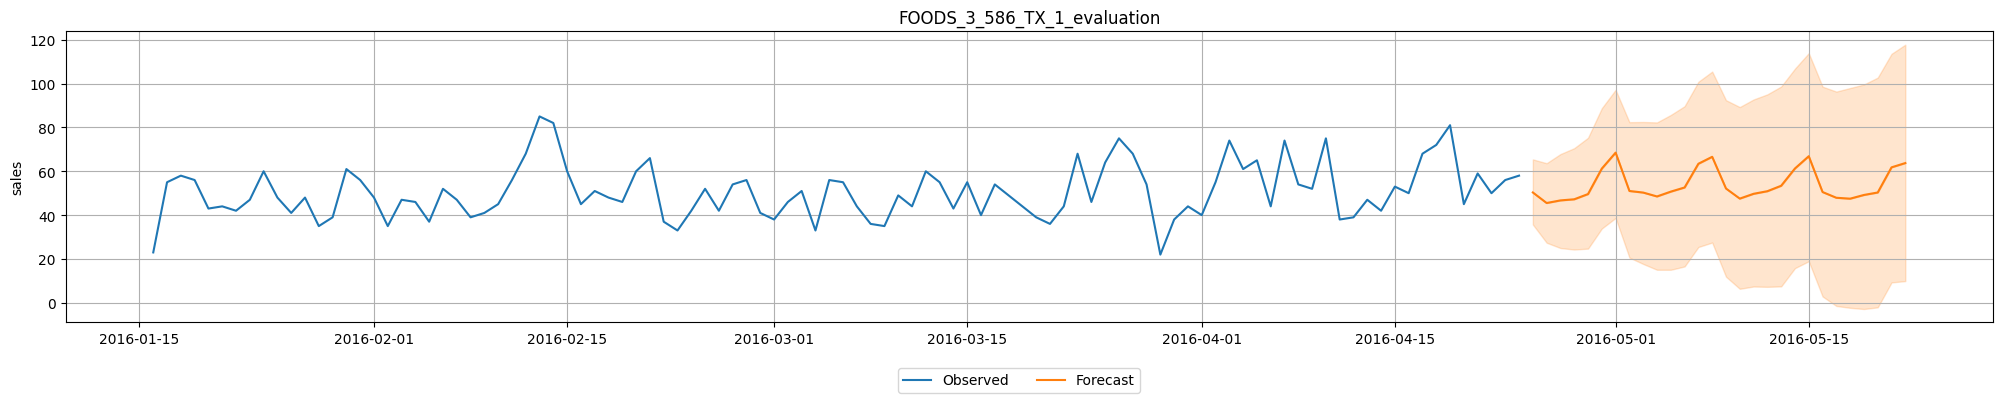

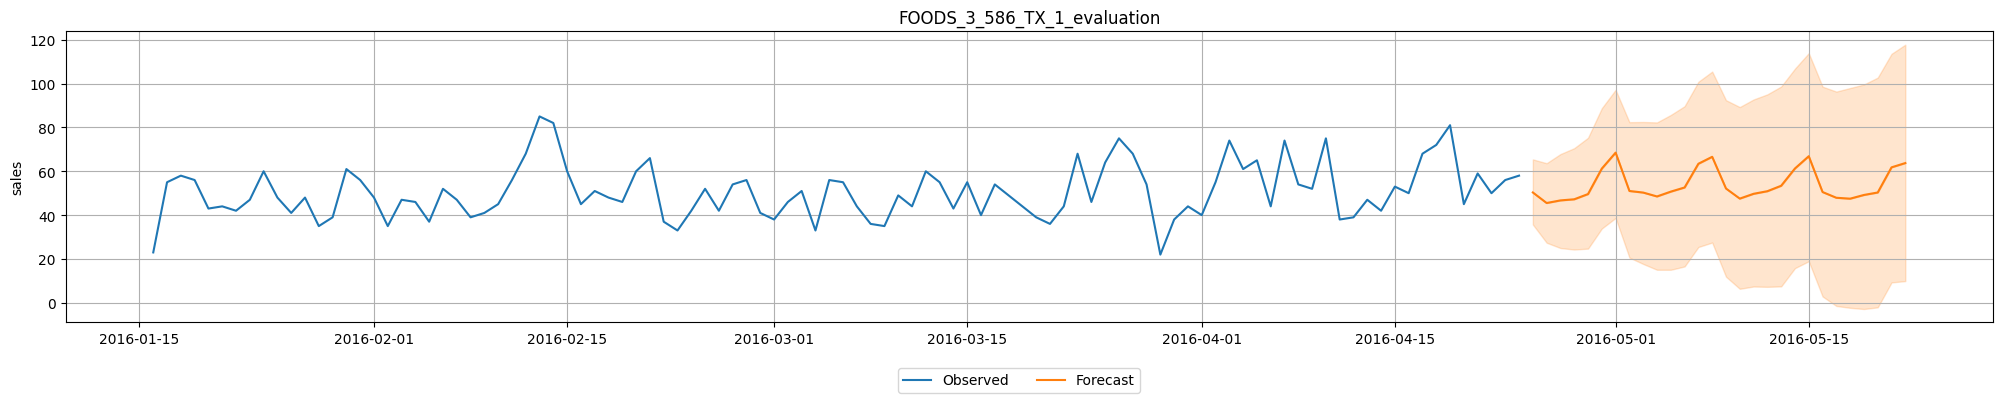

In [31]:
predictor.plot(
    data=train_set_for_autogluon,
    predictions=validation_preds,
    item_ids=[target_item_id],
    max_history_length=100  # Adjust as needed to display more or fewer historical points
)

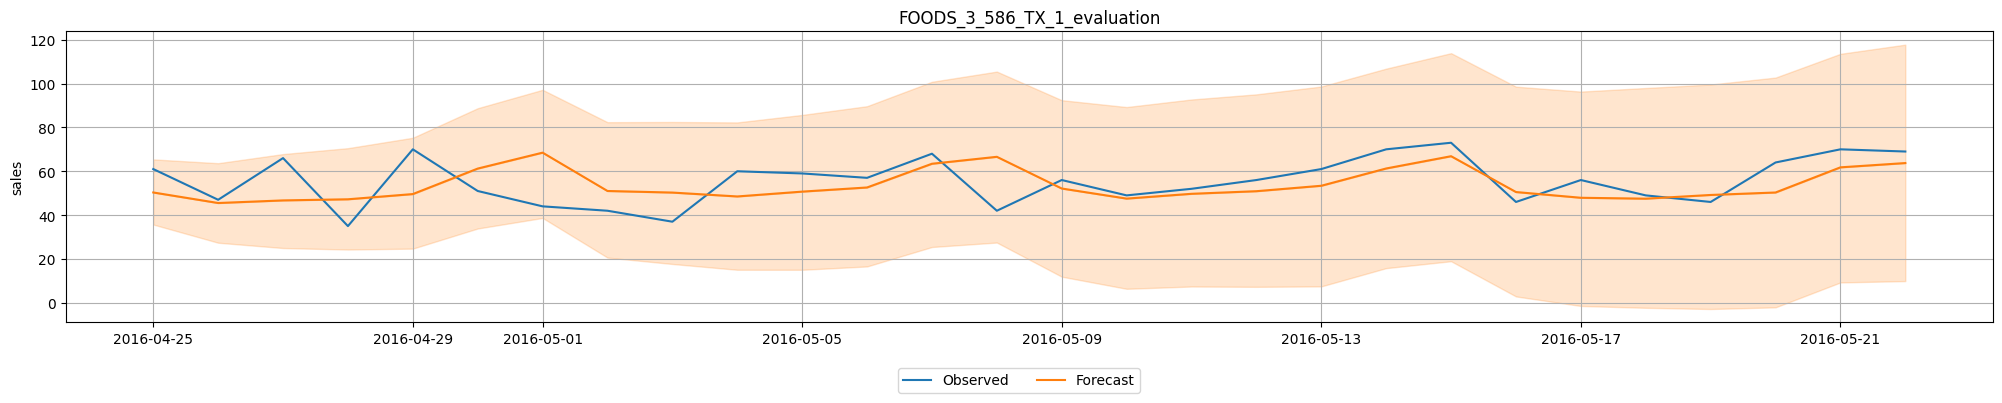

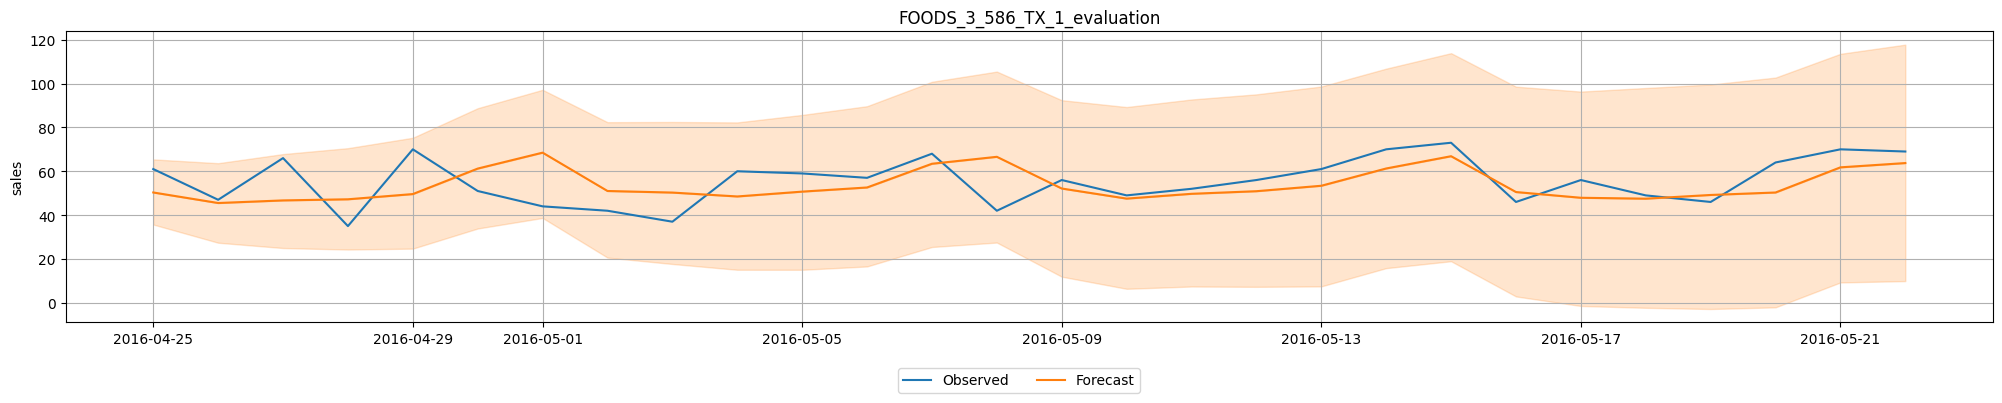

In [32]:
predictor.plot(
    data=validation_set_for_autogluon,
    predictions=validation_preds,
    item_ids=[target_item_id],
    max_history_length=28 
)

In [33]:
# Step 1: Extract the mean predictions
mean_predictions = validation_preds['mean']

# Step 2: Reshape the data
mean_predictions = mean_predictions.reset_index()
mean_predictions['forecast_day'] = mean_predictions.groupby('item_id').cumcount() + 1
validation_df = mean_predictions.pivot(index='item_id', columns='forecast_day', values='mean').reset_index()

# Step 3: Rename columns
validation_df.columns = ['id'] + [f'F{i}' for i in range(1, 29)]

# Step 4: Modify 'id' for submission
validation_df['id'] = validation_df['id'].str.replace('evaluation', 'validation')


In [34]:
validation_df

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_validation,1.076082,0.857693,0.993029,0.789837,0.840067,0.954485,0.966879,1.139879,0.943028,...,0.994072,1.073362,1.032260,1.188461,0.878274,1.027428,0.832780,0.924744,1.148848,1.021453
1,FOODS_1_001_CA_2_validation,1.303770,1.093900,1.253862,1.140736,1.220623,1.212529,1.993932,1.179874,1.195658,...,1.176907,1.294925,2.310597,1.233565,1.184821,1.337345,1.175869,1.214798,1.308058,2.161915
2,FOODS_1_001_CA_3_validation,1.068094,0.874633,1.019908,1.009813,1.114684,1.453237,1.570097,1.124954,1.217375,...,1.238522,1.270603,1.283650,1.188361,1.074703,1.116579,1.040504,1.113850,1.288394,1.336509
3,FOODS_1_001_CA_4_validation,0.461554,0.342495,0.371842,0.361795,0.400554,0.418807,0.416292,0.459441,0.343749,...,0.384575,0.402680,0.401741,0.397527,0.315188,0.346291,0.349843,0.437265,0.419927,0.424380
4,FOODS_1_001_TX_1_validation,0.286690,0.349958,0.390599,0.409546,0.427080,0.510302,0.582232,0.479590,0.524885,...,0.540740,0.582568,0.593468,0.427327,0.423322,0.495513,0.568517,0.557086,0.573818,0.531573
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,HOUSEHOLD_2_516_TX_2_validation,0.321545,0.281973,0.289411,0.282871,0.278261,0.346549,0.387964,0.310907,0.326339,...,0.328381,0.382419,0.389709,0.319143,0.287502,0.290194,0.265791,0.275020,0.340471,0.345526
30486,HOUSEHOLD_2_516_TX_3_validation,0.109157,0.139255,0.142510,0.131712,0.145542,0.153338,0.160677,0.141589,0.173300,...,0.245319,0.176766,0.165735,0.149193,0.147256,0.149163,0.140545,0.153429,0.183699,0.169410
30487,HOUSEHOLD_2_516_WI_1_validation,0.041995,0.040635,0.043106,0.040828,0.057973,0.060838,0.059957,0.058462,0.057147,...,0.066927,0.074727,0.075956,0.061375,0.055568,0.054250,0.063679,0.071966,0.077249,0.070697
30488,HOUSEHOLD_2_516_WI_2_validation,0.059662,0.072864,0.065762,0.074135,0.064171,0.063197,0.076561,0.076675,0.078033,...,0.072496,0.080999,0.076572,0.069751,0.066453,0.076881,0.096837,0.081714,0.083470,0.085302


# Predict for Prediction set

In [35]:
# Step 1: Ensure 'date' is in datetime format
prediction_set['date'] = pd.to_datetime(prediction_set['date'])

# Step 2: Select only the relevant columns, ensuring 'sales' is included and filled with NaN
covariate_columns = ['dept_id', 'store_id', 'wday', 'snap_CA', 'snap_TX', 'snap_WI', 'sell_price', 
                     'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
prediction_set_for_autogluon = prediction_set[['id', 'date'] + covariate_columns].copy()

# Step 4: Convert to AutoGluon TimeSeriesDataFrame, specifying `id_column` and `timestamp_column`
prediction_set_for_autogluon = TimeSeriesDataFrame(
    data=prediction_set_for_autogluon,
    id_column='id',
    timestamp_column='date'
)

In [36]:
# Concatenate the training and validation sets
combined_df = pd.concat([train_set_for_autogluon, validation_set_for_autogluon])

# Convert the concatenated DataFrame back to a TimeSeriesDataFrame
combined_tsdf = TimeSeriesDataFrame(combined_df)

In [37]:
%time
# Step 4: Make predictions using the prediction set as known covariates
prediction_preds = predictor.predict(combined_tsdf, known_covariates=prediction_set_for_autogluon)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.87 µs


Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


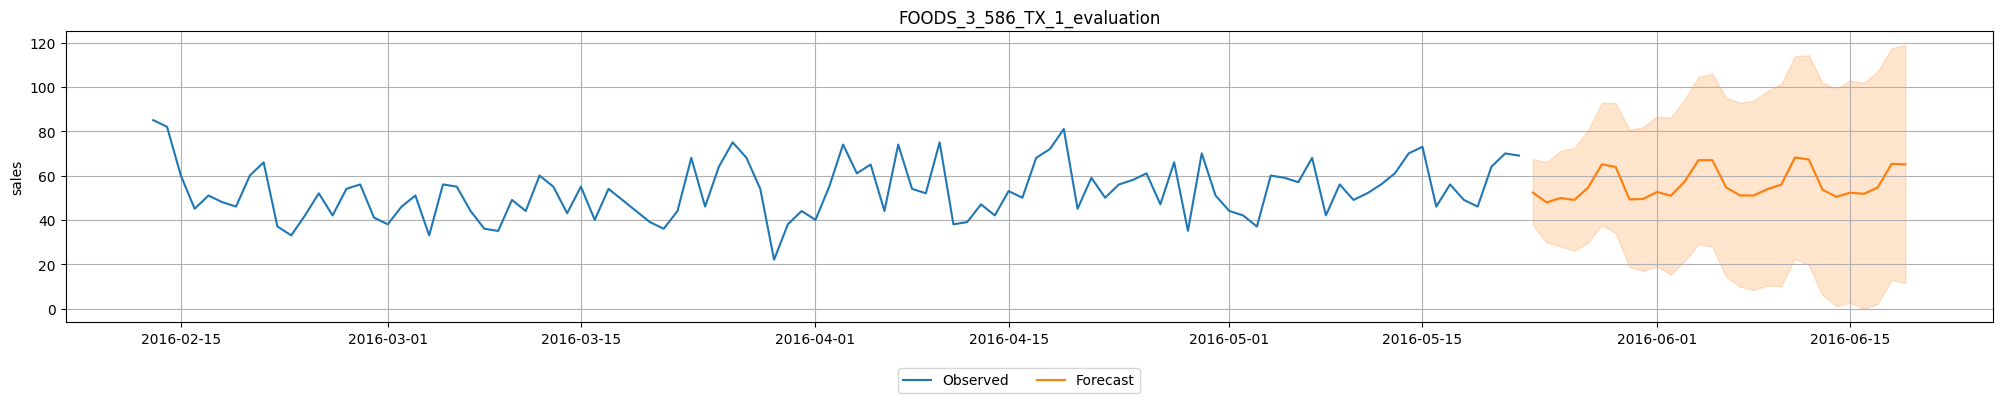

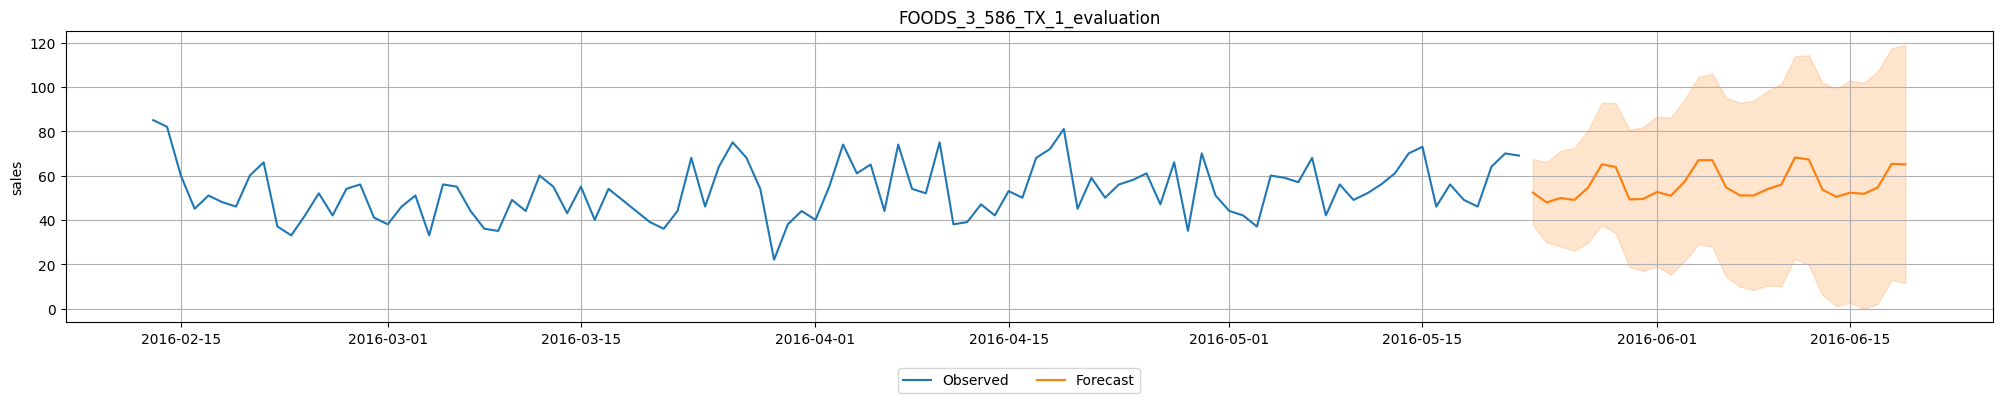

In [38]:
predictor.plot(
    data=combined_tsdf,
    predictions=prediction_preds,
    item_ids=[target_item_id],
    max_history_length=100  # Adjust as needed to display more or fewer historical points
)

In [39]:
# Step 1: Extract the mean predictions
mean_predictions1 = prediction_preds['mean']

# Step 2: Reshape the data
mean_predictions1 = mean_predictions1.reset_index()
mean_predictions1['forecast_day'] = mean_predictions1.groupby('item_id').cumcount() + 1
prediction_df = mean_predictions1.pivot(index='item_id', columns='forecast_day', values='mean').reset_index()

# Step 3: Rename columns
prediction_df.columns = ['id'] + [f'F{i}' for i in range(1, 29)]

In [40]:
prediction_df

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_evaluation,0.701381,0.744052,0.702773,0.706940,0.764729,0.877373,0.825940,0.761467,0.747361,...,0.765196,0.873464,0.872328,0.720943,0.743229,0.710942,0.699976,0.726336,0.884240,0.866558
1,FOODS_1_001_CA_2_evaluation,0.903127,0.840158,0.821234,0.786605,0.947610,0.979450,1.096173,0.857128,0.987615,...,1.077123,1.313307,1.103045,1.043717,1.078381,1.014187,0.973056,1.206249,1.172784,1.101195
2,FOODS_1_001_CA_3_evaluation,0.973423,0.908349,0.960924,1.010010,1.367359,1.637514,1.287817,0.971211,0.968763,...,1.296276,1.705544,1.405478,1.130242,1.156239,1.076002,0.975858,1.274457,1.607242,1.462928
3,FOODS_1_001_CA_4_evaluation,0.320676,0.269092,0.322897,0.294868,0.296571,0.288917,0.295418,0.291464,0.275392,...,0.284618,0.260010,0.281572,0.322523,0.306804,0.359541,0.340812,0.310449,0.282968,0.281326
4,FOODS_1_001_TX_1_evaluation,1.002454,1.037996,0.906433,0.951871,0.931690,0.989566,1.053312,0.889462,1.008431,...,0.938442,1.086825,1.332360,1.031324,1.197118,0.977027,1.131483,1.123757,0.993554,1.285638
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,HOUSEHOLD_2_516_TX_2_evaluation,0.253806,0.230018,0.228120,0.226290,0.267339,0.288096,0.321037,0.297108,0.259757,...,0.250517,0.318460,0.334512,0.265863,0.255328,0.265438,0.246488,0.236678,0.300243,0.321236
30486,HOUSEHOLD_2_516_TX_3_evaluation,0.398275,0.282676,0.304254,0.285674,0.341452,0.403611,0.341219,0.306259,0.277708,...,0.350393,0.421931,0.354677,0.336594,0.317494,0.309571,0.293516,0.333339,0.418312,0.423806
30487,HOUSEHOLD_2_516_WI_1_evaluation,0.095743,0.104834,0.104759,0.104688,0.176048,0.153708,0.207020,0.106226,0.102639,...,0.152186,0.114735,0.124551,0.119611,0.119313,0.114281,0.115380,0.116775,0.149011,0.129848
30488,HOUSEHOLD_2_516_WI_2_evaluation,0.094820,0.069630,0.073332,0.075328,0.074392,0.092501,0.116967,0.112250,0.086070,...,0.091274,0.099985,0.098785,0.114645,0.091055,0.084742,0.084590,0.093470,0.105667,0.101959


# For Submission

In [41]:
# Combine validation and evaluation for submission
submit = pd.concat([validation_df, prediction_df]).reset_index(drop=True)
submit.to_csv('submission.csv', index=False)

In [42]:
submit.head(10)

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_validation,1.076082,0.857693,0.993029,0.789837,0.840067,0.954485,0.966879,1.139879,0.943028,...,0.994072,1.073362,1.032260,1.188461,0.878274,1.027428,0.832780,0.924744,1.148848,1.021453
1,FOODS_1_001_CA_2_validation,1.303770,1.093900,1.253862,1.140736,1.220623,1.212529,1.993932,1.179874,1.195658,...,1.176907,1.294925,2.310597,1.233565,1.184821,1.337345,1.175869,1.214798,1.308058,2.161915
2,FOODS_1_001_CA_3_validation,1.068094,0.874633,1.019908,1.009813,1.114684,1.453237,1.570097,1.124954,1.217375,...,1.238522,1.270603,1.283650,1.188361,1.074703,1.116579,1.040504,1.113850,1.288394,1.336509
3,FOODS_1_001_CA_4_validation,0.461554,0.342495,0.371842,0.361795,0.400554,0.418807,0.416292,0.459441,0.343749,...,0.384575,0.402680,0.401741,0.397527,0.315188,0.346291,0.349843,0.437265,0.419927,0.424380
4,FOODS_1_001_TX_1_validation,0.286690,0.349958,0.390599,0.409546,0.427080,0.510302,0.582232,0.479590,0.524885,...,0.540740,0.582568,0.593468,0.427327,0.423322,0.495513,0.568517,0.557086,0.573818,0.531573
5,FOODS_1_001_TX_2_validation,0.427599,0.410023,0.490402,0.537679,0.516500,0.580745,0.573036,0.515596,0.474453,...,0.565870,0.548213,0.582465,0.550179,0.511091,0.473729,0.521216,0.524351,0.510888,0.578167
6,FOODS_1_001_TX_3_validation,0.406263,0.392210,0.428897,0.512916,0.546068,0.517829,0.561921,0.460297,0.433001,...,0.537462,0.483984,0.493752,0.464190,0.437601,0.439655,0.559747,0.512306,0.485798,0.456073
7,FOODS_1_001_WI_1_validation,0.716480,0.634605,0.713828,0.638464,0.707023,1.285512,0.717191,0.610937,0.594410,...,0.840375,1.359669,0.761682,0.623834,0.623901,0.604601,0.600625,0.591751,1.325503,0.759873
8,FOODS_1_001_WI_2_validation,0.332030,0.354059,0.467404,0.316813,0.268809,0.318709,0.426725,0.365401,0.394464,...,0.321135,0.338466,0.331187,0.314997,0.329679,0.506439,0.345353,0.324810,0.354290,0.355650
9,FOODS_1_001_WI_3_validation,0.338896,0.288344,0.303800,0.501424,0.342099,0.425385,0.341935,0.272919,0.277082,...,0.298541,0.387987,0.309637,0.276328,0.263104,0.246375,0.265832,0.328827,0.459898,0.326602


In [43]:
submit.tail(10)

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
60970,HOUSEHOLD_2_516_CA_1_evaluation,0.146809,0.160960,0.187323,0.182244,0.234515,0.230932,0.218592,0.178168,0.166600,...,0.254298,0.269708,0.261683,0.181083,0.172000,0.169620,0.185221,0.247371,0.255775,0.250842
60971,HOUSEHOLD_2_516_CA_2_evaluation,0.316142,0.367919,0.378184,0.347251,0.403827,0.404440,0.387051,0.343470,0.356686,...,0.414241,0.426096,0.408314,0.355898,0.367885,0.396448,0.376951,0.400553,0.458142,0.434903
60972,HOUSEHOLD_2_516_CA_3_evaluation,0.138620,0.204445,0.109997,0.116519,0.138119,0.131188,0.149474,0.133575,0.200279,...,0.129315,0.148097,0.144186,0.151011,0.151413,0.152487,0.128523,0.149554,0.157553,0.145764
60973,HOUSEHOLD_2_516_CA_4_evaluation,0.095159,0.113401,0.116653,0.111284,0.103279,0.120027,0.124004,0.128232,0.143578,...,0.140737,0.147191,0.143474,0.134207,0.119135,0.123947,0.117741,0.129182,0.145180,0.147591
60974,HOUSEHOLD_2_516_TX_1_evaluation,0.031764,0.034129,0.035826,0.037059,0.040301,0.048034,0.047542,0.039827,0.045115,...,0.057724,0.071091,0.066029,0.055199,0.056872,0.051958,0.057720,0.048331,0.073754,0.069839
60975,HOUSEHOLD_2_516_TX_2_evaluation,0.253806,0.230018,0.228120,0.226290,0.267339,0.288096,0.321037,0.297108,0.259757,...,0.250517,0.318460,0.334512,0.265863,0.255328,0.265438,0.246488,0.236678,0.300243,0.321236
60976,HOUSEHOLD_2_516_TX_3_evaluation,0.398275,0.282676,0.304254,0.285674,0.341452,0.403611,0.341219,0.306259,0.277708,...,0.350393,0.421931,0.354677,0.336594,0.317494,0.309571,0.293516,0.333339,0.418312,0.423806
60977,HOUSEHOLD_2_516_WI_1_evaluation,0.095743,0.104834,0.104759,0.104688,0.176048,0.153708,0.207020,0.106226,0.102639,...,0.152186,0.114735,0.124551,0.119611,0.119313,0.114281,0.115380,0.116775,0.149011,0.129848
60978,HOUSEHOLD_2_516_WI_2_evaluation,0.094820,0.069630,0.073332,0.075328,0.074392,0.092501,0.116967,0.112250,0.086070,...,0.091274,0.099985,0.098785,0.114645,0.091055,0.084742,0.084590,0.093470,0.105667,0.101959
60979,HOUSEHOLD_2_516_WI_3_evaluation,0.050013,0.048009,0.051258,0.054289,0.067408,0.104650,0.083236,0.065425,0.069041,...,0.072915,0.084798,0.097542,0.087589,0.081023,0.077913,0.068974,0.071386,0.091256,0.086781
